In [ ]:
%cd "Paciente 17"

/content/Paciente 17


In [ ]:
import pandas as pd

test = pd.read_csv('Teste.csv')
train = pd.read_csv('Treino.csv')

label_column = test.columns[-1]

Y_test = test[label_column]
Y_train = train[label_column]

X_test = test.drop(columns=label_column)
X_train = train.drop(columns=label_column)

In [ ]:
import plotly.express as px

train['split'] = 'train'
test['split'] = 'test'


data = pd.concat([train, test], ignore_index=True).rename(columns={label_column: 'label', '1': 'count'})
data['label'] = data['label'].map({1: 'Normal', -1: 'Extra Sistólico'})
data_count = data.groupby(['split', 'label'])['count'].count().reset_index()


px.bar(data_count, x='split', y='count', color='label', color_discrete_map={'Normal': 'darkolivegreen', 'Extra Sistólico': 'red'})

In [ ]:
import plotly.express as px


transform_data = pd.melt(train.reset_index(), id_vars=[label_column, 'index']).rename(columns={'index': 'amostra', label_column:'batimento', 'value': 'amplitude'}).reset_index()
transform_data['Tempo [(*1/360)]s'] = transform_data['index']/360
transform_data['batimento'] = transform_data['batimento'].map({1: 'Normal', -1: 'Extra Sistólico'})


labels = {'amplitude': 'amplitude mv[100]'}
fig = px.line(transform_data, x='Tempo [(*1/360)]s', y='amplitude', color='amostra', facet_col='batimento', color_discrete_sequence=px.colors.qualitative.Prism, labels=labels,  width=800, height=500)
fig.update_traces(textfont=dict(size=28))
fig

In [ ]:
from sklearn.cluster import KMeans

n_labels=train[label_column].value_counts().count()
seed = 1

km = KMeans(n_clusters=n_labels, random_state=seed).fit(X_train)
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import manhattan_distances

cluster_mapping = dict()
for idx, center in enumerate(km.cluster_centers_):
  distance = manhattan_distances(X_train, [center]).flatten()
  label = Y_train[distance == distance.min()].iloc[0]

  cluster_mapping[idx] = label

print(cluster_mapping)

{0: 1, 1: -1}


In [ ]:
raw_predictions = km.predict(X_test)
predictions = [cluster_mapping[pred] for pred in raw_predictions]

#### **Gera a matriz de confusão e acurácia total da classificação**


> As linhas são a referência (y real)
>> Linha 1 = Batimentos extra sistólicos <br>
Linha 2 = Batimentos normais 


> As colunas correspondem a saida do modelo
>> Coluna 1 = Batimentos extra sistólicos <br>
Coluna 2 = batimentos normais


In [ ]:
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff


labels = ['Normal', 'Extra Sistólico']
conf_matrix = confusion_matrix(Y_test, predictions, labels=[1, -1])

fig = ff.create_annotated_heatmap(conf_matrix, x=labels, y=labels, showscale=True, colorscale="tempo")
fig.update_layout(width=400, height=400)

fig

In [ ]:
from sklearn.metrics import classification_report

clf_report = classification_report(Y_test, predictions, target_names=labels)
print(clf_report)

                 precision    recall  f1-score   support

         Normal       0.67      0.38      0.49        26
Extra Sistólico       0.85      0.95      0.90        99

       accuracy                           0.83       125
      macro avg       0.76      0.67      0.69       125
   weighted avg       0.82      0.83      0.81       125



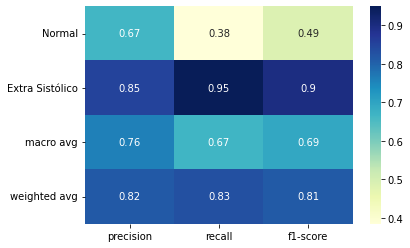

In [ ]:
import seaborn as sns


clf_report = classification_report(Y_test, predictions, target_names=labels, output_dict=True)
col_order = ['Normal', 'Extra Sistólico', 'macro avg', 'weighted avg', 'accuracy']
clf_report = pd.DataFrame(clf_report)[col_order].drop(columns=['accuracy']).iloc[:-1, :].T

sns.heatmap(clf_report, annot=True, cmap="YlGnBu")

In [ ]:
import plotly.express as px

pred_label = pd.DataFrame({'label': Y_test, 'prediction': predictions})
result = pd.concat([X_test, pred_label], axis=1)
transform_data = pd.melt(result.reset_index(), id_vars=['label', 'index', 'prediction'])
transform_data =  transform_data.rename(columns={'index': 'amostra', 'label': 'batimento', 'value': 'amplitude', 'prediction': 'predito'}).reset_index()
transform_data['batimento'] = transform_data['batimento'].map({1: 'Normal', -1: 'Extra Sistólico'})
transform_data['predito'] = transform_data['predito'].map({1: 'Normal', -1: 'Extra Sistólico'})
transform_data['Tempo [(*1/360)]s'] = transform_data['index']/360


labels = {'amplitude': 'amplitude mv[100]'}
fig = px.line(
    transform_data,
    x='Tempo [(*1/360)]s',
    y='amplitude',
    color='amostra',
    facet_row='batimento',
    facet_col='predito',
    color_discrete_sequence=px.colors.qualitative.Prism, labels=labels,  width=480, height=500)
fig.update_layout(showlegend=False)
fig